# Reproducible Analyses of BECLEAN Manuscript
This document contains the reproducible workflow that performed the analyses presented in the manuscript of BECLEAN.

## 1.Background Species Profiling
This section analyzes the sequencing data of the synthetic DNA library preparation carried out in labA by automated approach, aiming to identify and investigate the community composition of background contaminants. Non-human non-spike reads are deposited under SRA project accession PRJNA665350. Sample metadata and alignment result are included as part of this reproducible analysis in the *training_set* directory.
### Prepare Workspace
Load libraries.

In [5]:
import os
import json
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn
import pandas as pd
import numpy as np
import math
from scipy import stats
import glob
from collections import defaultdict
import skbio
from scipy.spatial import distance_matrix, distance
import random

Settings and global variables.

In [2]:
params = {'mathtext.default': 'regular', 'figure.dpi': 150}          
plt.rcParams.update(params)
WORK_DIR = '/BECLEAN'  # CHANGE ME

Load data.

In [26]:
# alignment results of non-human non-spike reads from bioinformatics analysis
with open(os.path.join(WORK_DIR, 'training_set', 'alignment_results.json')) as f:
    alignment_results = json.load(f)

# metadata of sample
sample_metadata = pd.read_excel(os.path.join(WORK_DIR, 'training_set', 'meta.xlsx'))

# taxid-scientific name map
with open(os.path.join(WORK_DIR, 'taxid2name.json')) as f:
    scientific_names = json.load(f)

### Candidates Filtering And Modeling
Get frequence statistics of background species detected in labA by aotomated library preparation approach.

In [4]:
def get_frequence_stats(alignment_results, sample_metadata, lab='labA', method='automated', top_n=None):
    sample_subset = sample_metadata[(sample_metadata.lab == lab) & (sample_metadata.method == method)].sample_name.values
    results_subset = {sample_name: alignment_results[sample_name] for sample_name in sample_subset}
    taxid_frequence = defaultdict(int)
    for sample_name, sample_result in results_subset.items():
        for taxid, reads in sample_result.items():
            taxid_frequence[taxid] += 1
    n_frequence = sorted(taxid_frequence.values(), reverse=True)[top_n-1] if top_n else 0
    return {taxid: frequence for taxid, frequence in taxid_frequence.items() if frequence >= n_frequence}

top_60 = get_frequence_stats(alignment_results, sample_metadata, top_n=60)

Apply threshold filter: frequence ≥ 20.

In [5]:
candidates_f20 = {taxid: frequence for taxid, frequence in top_60.items() if frequence >= 20}
print(f'{len(candidates_f20)} candidates left after threshold filter')

38 candidates left after threshold filter


Modeling, exclude data points which lay out of the linearity range, do normality test.

In [6]:
# helper functions
def get_df_of_taxid(taxid, alignment_results, sample_metadata, lab='labA', method='automated', nucleic_acid_mass=True):
    sample_subset = sample_metadata[(sample_metadata.lab == lab) & (sample_metadata.method == method)].sample_name.values
    results_subset = {sample_name: alignment_results[sample_name] for sample_name in sample_subset}
    sample_names, rpms, library_concentrations, nucleic_acid_masses = [], [], [], []
    for sample_name, sample_result in results_subset.items():
        sample_meta = sample_metadata[sample_metadata.sample_name == sample_name]
        if taxid in sample_result:
            sample_names.append(sample_name)
            rpms.append(round((sample_result[taxid] / sample_meta.total_reads.values[0] * 1_000_000), 2))
            library_concentrations.append(sample_meta.library_concentration.values[0])
            if nucleic_acid_mass:
                nucleic_acid_masses.append(sample_meta.nucleic_acid_mass.values[0])
            else:
                nucleic_acid_masses.append(np.nan)
    df = pd.DataFrame(
        dict(sample_name=sample_names, rpm=rpms, library_concentration=library_concentrations, nucleic_acid_mass=nucleic_acid_masses))
    df['log_rpm'] = df.rpm.map(math.log2)
    df['log_library_concentration'] = df.library_concentration.map(math.log2)
    df['log_nucleic_acid_mass'] = df.nucleic_acid_mass.map(math.log2)
    return df

def get_model_of_taxid(df, taxid, key='log_library_concentration'):
    """
    input:
        df: pandas dataframe containing sample meta data and rpm of given species,
            columns are: sample_name, rpm, library_concentration, nucleic_acid_mass, log_rpm,
            log_library_concentration, log_nucleic_acid_mass
        taxid: taxid of species
        key: column name of the value represents the sample input,
            valid values: 'log_library_concentration'(default), 'log_nucleic_acid_mass'
    output:
        dictionary including taxid, model parameters, and data summary
        keys are: taxid, slope, intercept, sd, rvalue, pvalue, con_mean(average of value specified as sample input),
        rpm_mean(average of model normalized rpm), cutoff(maximum value of sample input within the linearity range),
        frequence(occurrence of frequency), and normaltest_p(normality test p value)
    """
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(df[key], df.log_rpm)
    cutoff = (math.log2(1 / 10_000_000 * 1_000_000) - intercept) / slope
    df_valid = df[df[key] <= cutoff]
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_valid[key], df_valid.log_rpm)
    residual = df.log_rpm - (slope * df[key] + intercept)
    k2r, pr = stats.normaltest(residual)
    df['log_rpm_norm'] = df.log_rpm + slope * (df[key].mean() - df[key])
    k2, p = stats.normaltest(df.log_rpm_norm)
    model = dict(taxid=taxid, slope=slope, intercept=intercept, sd=df.log_rpm_norm.std(), rvalue=rvalue, pvalue=pvalue,
                 con_mean=df[key].mean(), rpm_mean=df.log_rpm_norm.mean(),
                 cutoff=cutoff, frequence=len(df), normaltest_p=p, residual_p=pr)
    return model

def get_models(taxids, alignment_results, sample_metadata, lab='labA', method='automated', key='log_library_concentration'):
    models = {}
    for taxid in taxids:
        df = get_df_of_taxid(taxid, alignment_results, sample_metadata, lab, method)
        models[taxid] = get_model_of_taxid(df, taxid, key)
    return models

# get models of candidates
labA_automated_models_f20 = get_models(candidates_f20.keys(), alignment_results, sample_metadata)
print(f'Models with linear regression p value < 0.05: \
{len(list(filter(lambda x: x["pvalue"] < 0.05, labA_automated_models_f20.values())))}/{len(labA_automated_models_f20)}')

Models with linear regression p value < 0.05: 38/38


Plot figure 1b and figure 1c.

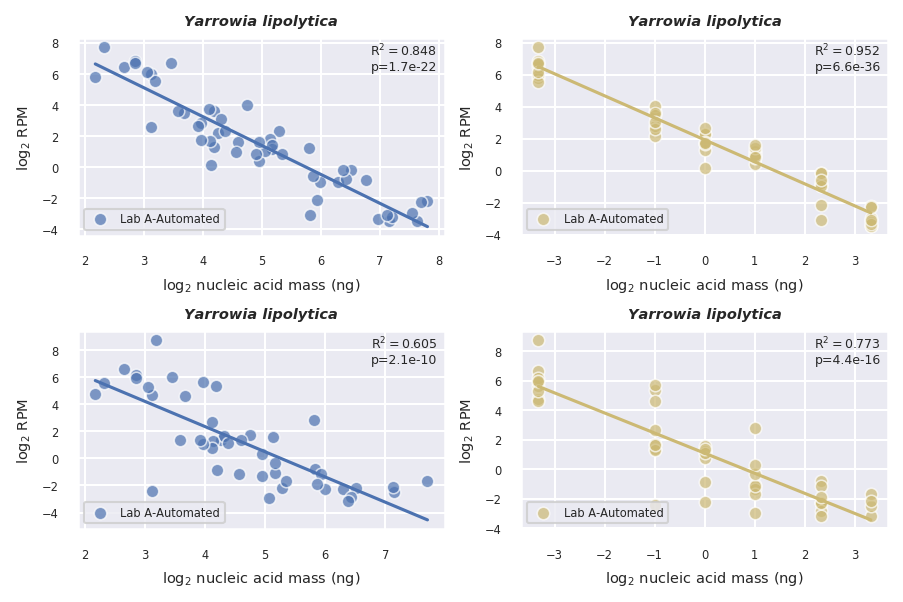

In [7]:
# taxid of Yarrowia lipolytica and Moraxella osloensis
taxids = ['4952', '34062']

# get models of these two species featured by nucleic acid mass
nucleic_acid_mass_models = {taxid: get_model_of_taxid(
    get_df_of_taxid(taxid, alignment_results, sample_metadata), taxid, 'log_nucleic_acid_mass') for taxid in taxids}

# helper functions
def get_y_coor(model, x, z=0):
    return model['intercept'] + model['slope'] * x + z * model['sd']

def get_df_by_model(model, key='log_library_concentration'):
    df = get_df_of_taxid(model['taxid'], alignment_results, sample_metadata)
    df = df[df[key] <= model['cutoff']]
    return df

# plot
seaborn.set(font_scale=0.5)
fig, axes = plt.subplots(2, 2)
axes_data = [
    {'taxid': '4952', 'color': 'b', 'idx1': 0, 'idx2': 0, 'key': 'log_library_concentration', 'model': labA_automated_models_f20['4952']},
    {'taxid': '4952', 'color': 'y', 'idx1': 0, 'idx2': 1, 'key': 'log_nucleic_acid_mass', 'model': nucleic_acid_mass_models['4952']},
    {'taxid': '4952', 'color': 'b', 'idx1': 1, 'idx2': 0, 'key': 'log_library_concentration', 'model': labA_automated_models_f20['34062']},
    {'taxid': '4952', 'color': 'y', 'idx1': 1, 'idx2': 1, 'key': 'log_nucleic_acid_mass', 'model': nucleic_acid_mass_models['34062']}
]
for idx in range(4):
    ax_data = axes_data[idx]
    ax = axes[ax_data['idx1'], ax_data['idx2']]
    color = ax_data['color']
    species_name = scientific_names[ax_data['taxid']]
    key = ax_data['key']
    model = ax_data['model']
    df = get_df_by_model(model, key)
    seaborn.scatterplot(x=key, y='log_rpm', data=df, ax=ax, alpha=0.7, color=color, label='Lab A-Automated')
    xlim = df[key].min(), df[key].max()
    line = pd.DataFrame.from_records([{key: x, 'log_rpm': get_y_coor(model, x)} for x in xlim])
    seaborn.lineplot(x=key, y='log_rpm', data=line, ax=ax, color=color)
    text = f'$R^2={round(math.pow(model["rvalue"], 2), 3)}$\np={model["pvalue"]:.1e}'
    ax.text(0.98, 0.98, text, horizontalalignment='right', verticalalignment='top', fontsize=6, transform=ax.transAxes)
    ax.legend(loc='lower left')
    ax.set_title(species_name, fontweight='bold', style='italic', fontsize=7)
    if key == 'log_lib_concentration':
        ax.set_xlabel(r'$log_2$ library concentration (pM)', fontsize=7)
    else:
        ax.set_xlabel(r'$log_2$ nucleic acid mass (ng)', fontsize=7)
    ax.set_ylabel(r'$log_2$ RPM', fontsize=7)
fig.tight_layout()
plt.show()
plt.close()

Exclude species failed normality test (*p* > 0.05)

In [8]:
# helper functions
def filter_model_by_normality_p(models, p=0.05):
    passed = {taxid: model for taxid, model in models.items() if model['normaltest_p'] > p}
    return passed
    
# final background species
labA_automated_models = filter_model_by_normality_p(labA_automated_models_f20)
print(f'Models passed normality test (p > 0.05): {len(labA_automated_models)}/{len(labA_automated_models_f20)}')

Models passed normality test (p > 0.05): 32/38


Plot figure 1e.

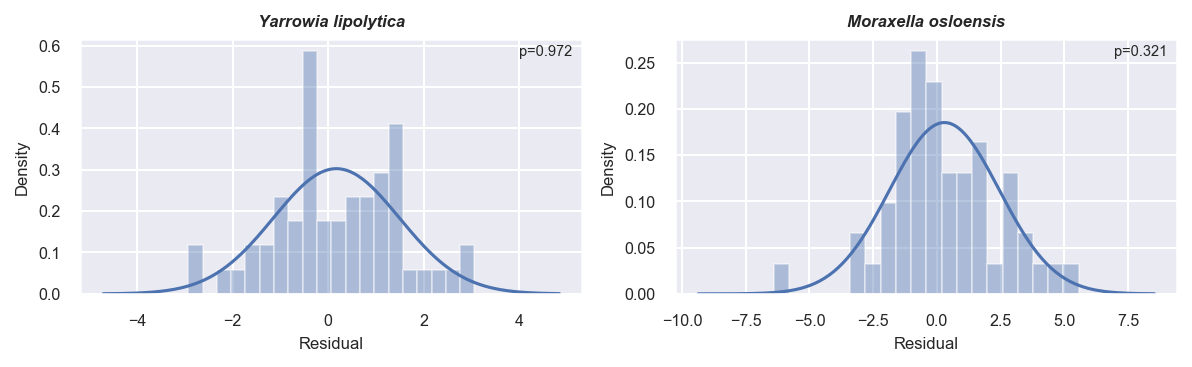

In [9]:
# helper functions
def get_normed_df(model, key='log_library_concentration'):
    df = get_df_of_taxid(model['taxid'], alignment_results, sample_metadata)
    df['log_rpm_norm'] = df.log_rpm + model['slope'] * (df[key].mean() - df[key])
    return df

# plot
seaborn.set(font_scale=0.7)
fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
axes_data = [
    {'taxid': '4952', 'idx': 0, 'model': labA_automated_models['4952'], 'data': get_normed_df(labA_automated_models['4952'])},
    {'taxid': '34062', 'idx': 1, 'model': labA_automated_models['34062'], 'data': get_normed_df(labA_automated_models['34062'])}
]
for idx in range(2):
    ax_data = axes_data[idx]
    ax = axes[ax_data['idx']]
    model = ax_data['model']
    data = ax_data['data']
    data['residual'] = data.log_rpm - (model['slope'] * data['log_library_concentration'] + model['intercept'])
    species_name = scientific_names[ax_data['taxid']]
    seaborn.distplot(data.residual, fit=stats.norm, kde=False, bins=20, fit_kws={'color': 'b'}, ax=ax)
    text = f'p={round(model["residual_p"], 3)}'
    ax.text(0.98, 0.98, text, horizontalalignment='right', verticalalignment='top', fontsize=7, transform=ax.transAxes)
    ax.set_title(species_name, fontweight='bold', style='italic', fontsize=8)
    ax.set_xlabel('Residual', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
fig.tight_layout()
plt.show()
plt.close()

Plot figure 1h.

In [30]:
def pcoa_test(data, meta, style='run', style_order=['run1', 'run2']):  # columns: taxid, row: sample
    seaborn.set()
    random.seed(0)
    dist_m = distance.squareform(distance.pdist(data, metric='braycurtis'))
    dist_matrix = skbio.stats.distance.DistanceMatrix(dist_m, ids=data.index.values)
    pcoa = skbio.stats.ordination.pcoa(dist_matrix)
    df = pcoa.samples.copy()
    df['sample_name'] = df.index.values
    df = pd.merge(df, meta[['run', 'nucleic_acid_mass', 'sample_name']], on='sample_name', how='left')
    print(skbio.stats.distance.permanova(dist_matrix, df.run.values))
    ax = seaborn.scatterplot(data=df, x='PC1', y='PC2', hue='nucleic_acid_mass', style=style,
                         palette=seaborn.cubehelix_palette(8), style_order=style_order)
    h,l = ax.get_legend_handles_labels()
    l[0] = 'DNA input mass'
    ax.legend(h, l, fontsize='small', bbox_to_anchor=(1, 1))
    ax.set_xlabel(f'PCoA 1 ({pcoa.proportion_explained[0]*100:.2f}%)', fontsize=13, fontweight='bold')
    ax.set_ylabel(f'PCoA 2 ({pcoa.proportion_explained[1]*100:.2f}%)', fontsize=13, fontweight='bold')
    ax.tick_params(axis='both', which='major')
    plt.tight_layout()
    plt.show()
    plt.close()

/home/analysis/.conda/envs/core/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.05820890757321322 and the largest is 7.289749876047403.
  RuntimeWarning


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      72
number of groups                  2
test statistic             0.483216
p-value                       0.924
number of permutations          999
Name: PERMANOVA results, dtype: object


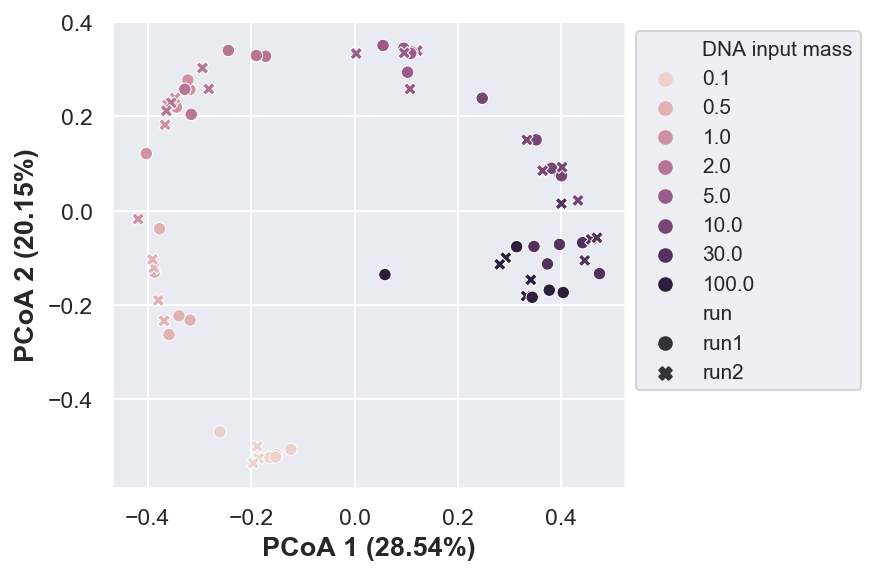

In [70]:
labA_pcoa_data = pd.read_excel(os.path.join(WORK_DIR, 'training_set', 'labA_pcoa_data.xlsx'), index_col=[0]).T
pcoa_test(labA_pcoa_data, sample_metadata)

Plot figure 1i

In [78]:
def plot_cosine_distance(model_df, total):
    res = []
    for taxid in set(model_df.taxid.values):
        taxid_df = model_df[model_df.taxid == taxid]
        run1 = taxid_df[taxid_df.run == 'run1']
        run2 = taxid_df[taxid_df.run == 'run2']
        run_all = taxid_df[taxid_df.run == 'all']
        f = run_all.frequence.values[0] / total
        dist = distance.cosine([1, run1.slope.values[0]], [1, run2.slope.values[0]])
        res.append({'taxid': taxid, 'frequency': f, 'dist': dist, '$R^2$': (run1.r2.values[0] + run2.r2.values[0]) / 2})
    df = pd.DataFrame.from_records(res)
    df['sim'] = 1 - df['dist']
    seaborn.scatterplot(data=df, x='frequency', y='sim', hue='$R^2$', alpha=0.9)
    norm = plt.Normalize(df['$R^2$'].min(), df['$R^2$'].max())
    sm = plt.cm.ScalarMappable(cmap=seaborn.cubehelix_palette(as_cmap=True), norm=norm)
    sm.set_array([])
    clb = plt.colorbar(sm)
    clb.ax.get_yaxis().labelpad = 15
    clb.ax.set_ylabel('$R^2$', fontweight='bold', rotation=270)
    plt.xlabel('Relative Frequency', fontsize=13, fontweight='bold')
    plt.ylabel('Cosine Similarity', fontsize=13, fontweight='bold')
    plt.ylim([0, 1.05])
    plt.legend().remove()
    plt.show()
    plt.close()

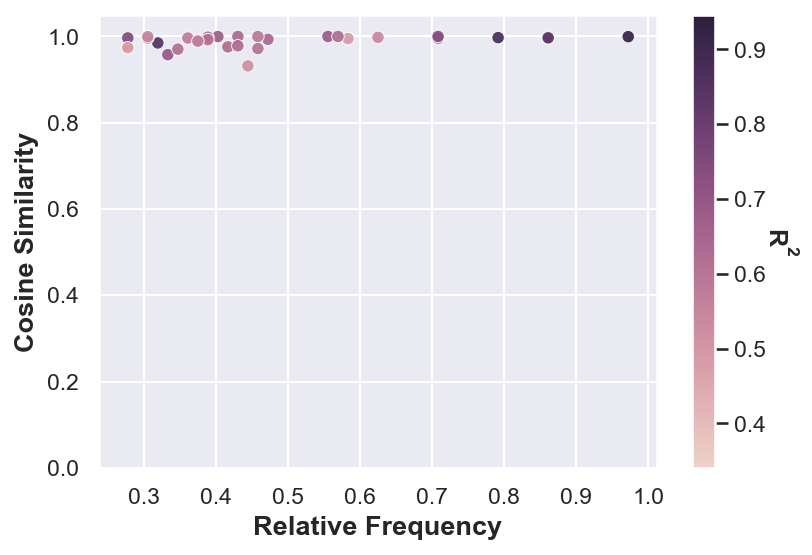

In [79]:
labA_model_sep_df = pd.read_excel(os.path.join(WORK_DIR, 'training_set', 'labA_model_sep.xlsx'))
plot_cosine_distance(labA_model_sep_df, total=72)

Genome coverage. Genome depth data of all 72 samples of each taxon generated by samtools are included in the *coverage* directory named in {taxid}\_depth.txt format. In addition, genome accession length data are also included in the *coverage* directory named {taxid}.json. Owing to the different resolution of notebook and pdf file, figure presented below may look a little different from fiugre in Supplemental Figure 3.

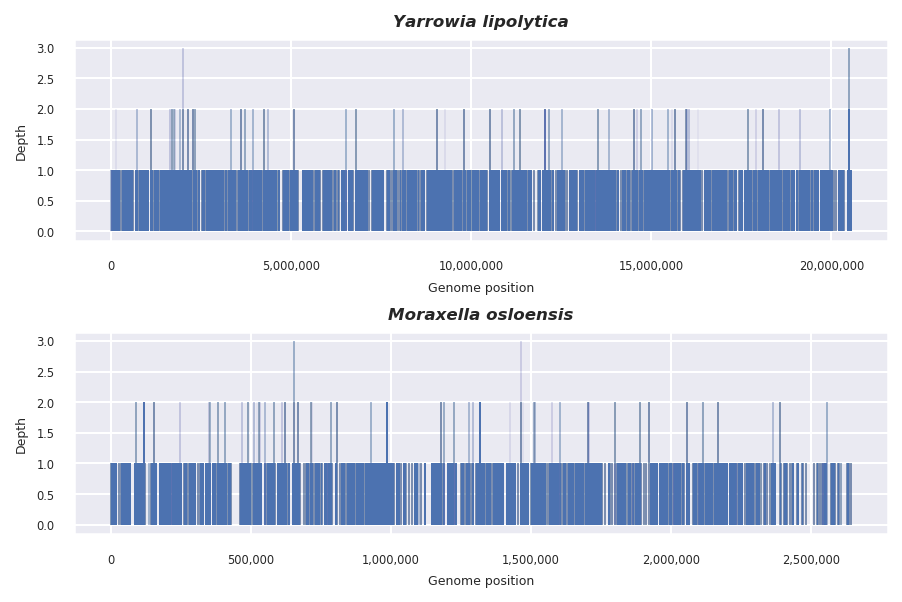

In [10]:
# taxid of Yarrowia lipolytica and Moraxella osloensis
taxids = ['4952', '34062']

# load data
# samtool-depth data
coverage_data = {taxid: pd.read_csv(os.path.join(WORK_DIR, 'training_set', 'coverage', f'{taxid}_depth.txt'), sep='\t', header=None,
                                   names=['accession', 'position', 'depth']) for taxid in taxids}
# accession length data of genome, to concatenate multiple accessions
accession_data = {}
for taxid in taxids:
    with open(os.path.join(WORK_DIR, 'training_set', 'coverage', f'{taxid}.json')) as f:
        accession_data[taxid] = json.load(f)
        
# plot
seaborn.set(font_scale=0.5)
fig, axes = plt.subplots(2, 1)
for idx, taxid in enumerate(taxids):
    species_name = scientific_names[taxid]
    accession_length = {}
    added = 0
    for accession, length in accession_data[taxid].items():
        accession_length[accession] = added
        added += length
    depth = coverage_data[taxid]
    depth['add'] = depth.accession.map(lambda x: accession_length[x])
    depth['position_cumulated'] = depth['position'] + depth['add']
    markerline, stemlines, baseline = axes[idx].stem(depth.position_cumulated, depth.depth, markerfmt=' ', basefmt=' ',
                                                     use_line_collection=True)
    plt.setp(stemlines, 'linewidth', 0.02)
    plt.setp(stemlines, 'alpha', 0.5)
    axes[idx].set_title(species_name, fontweight='bold', style='italic', fontsize=8)
    axes[idx].set_xlabel('Genome position')
    axes[idx].set_ylabel('Depth')
    axes[idx].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.tight_layout()
plt.show()
plt.close()

### Export Data
Export data requeired for figure 1d and figure 1f.

In [11]:
frequence_df = pd.DataFrame.from_dict({'taxid': list(top_60.keys()), 'frequence': list(top_60.values())})
taxid_name_df = pd.DataFrame.from_dict({'taxid': list(scientific_names.keys()), 'scientific_name': list(scientific_names.values())})
model_f20_metrics = [
    {'taxid': model['taxid'], 'r_squared': math.pow(model['rvalue'], 2), 'pvalue': model['pvalue'], 'normaltest_p': model['normaltest_p']}
    for model in labA_automated_models_f20.values()]
model_f20_df = pd.DataFrame.from_records(model_f20_metrics)
export_data_df = pd.merge(pd.merge(frequence_df, taxid_name_df, how='left', on='taxid'), 
                          model_f20_df, how='left', on='taxid').sort_values(by=['frequence', 'taxid'], ascending=False)
export_data_df.to_excel(os.path.join(WORK_DIR, 'training_set', 'frequence_model_metrics.xlsx'), index=None)

## 2. Analysis of simulated samples
This section analyzes the sequencing data of the simulated samples of a dilution series, which are with or without spike-in mix of 4 background contaminants (*Yarrowia lipolytica*, *Moraxella osloensis*, *Acinetobacter johnsonii* and *Acinetobacter junii*). Non-human non-spike reads are deposited under SRA project accession PRJNA665328. Sample metadata and alignment result are included as part of this reproducible analysis in the *simulated_samples* directory.

### Data Preparation
Load data.

In [12]:
# alignment results of non-human non-spike reads from bioinformatics analysis
simulated_sample_alignment_results = {}
with open(os.path.join(WORK_DIR, 'simulated_samples', 'alignment_results_1e4_cells.json')) as f:
    simulated_sample_alignment_results['1e4_cells'] = json.load(f)
with open(os.path.join(WORK_DIR, 'simulated_samples', 'alignment_results_1e5_cells.json')) as f:
    simulated_sample_alignment_results['1e5_cells'] = json.load(f)
# metadata of sample
simulated_sample_metadata = {'1e4_cells': pd.read_excel(os.path.join(WORK_DIR, 'simulated_samples', 'meta.xlsx'), sheet_name='1e4_cells'),
                             '1e5_cells': pd.read_excel(os.path.join(WORK_DIR, 'simulated_samples', 'meta.xlsx'), sheet_name='1e5_cells')}

Get rpm and zscore data.

In [13]:
# taxid of Yarrowia lipolytica, Moraxella osloensis, Acinetobacter johnsonii and Acinetobacter junii
taxids = ['4952', '34062', '40214', '40215']

# helper functions
def calculate_z_score(model, library_concentration, rpm):
    if not rpm:
        return np.nan
    rpm_norm = math.log2(rpm) + model['slope'] * (model['con_mean'] - math.log2(library_concentration))
    zscore = (rpm_norm - model['rpm_mean']) / model['sd']
    return zscore

def get_rpm_and_zscore(taxids, alignment_results, sample_metadata, models):
    zscores, rpms = {}, {}
    for taxid in taxids:
        scientific_name = scientific_names[taxid]
        zscores[scientific_name] = []
        rpms[scientific_name] = []
        for i, row in sample_metadata.iterrows():
            if taxid in alignment_results[row.sample_name]:
                rpm = round(alignment_results[row.sample_name][taxid] / row.total_reads * 1_000_000, 2)
            else:
                rpm = np.nan
            zscore = calculate_z_score(models[taxid], row.library_concentration, rpm)
            zscores[scientific_name].append(zscore)
            rpms[scientific_name].append(rpm)
    zscore_df = pd.DataFrame(zscores, index=sample_metadata.sample_name)
    rpm_df = pd.DataFrame(rpms, index=sample_metadata.sample_name)
    return zscore_df, rpm_df

simulated_plot_data = {'1e4_cells': get_rpm_and_zscore(taxids, simulated_sample_alignment_results['1e4_cells'],
                                                       simulated_sample_metadata['1e4_cells'], labA_automated_models),
                       '1e5_cells': get_rpm_and_zscore(taxids, simulated_sample_alignment_results['1e5_cells'],
                                                       simulated_sample_metadata['1e5_cells'], labA_automated_models)}

### Plotting
Plot figure 2b.

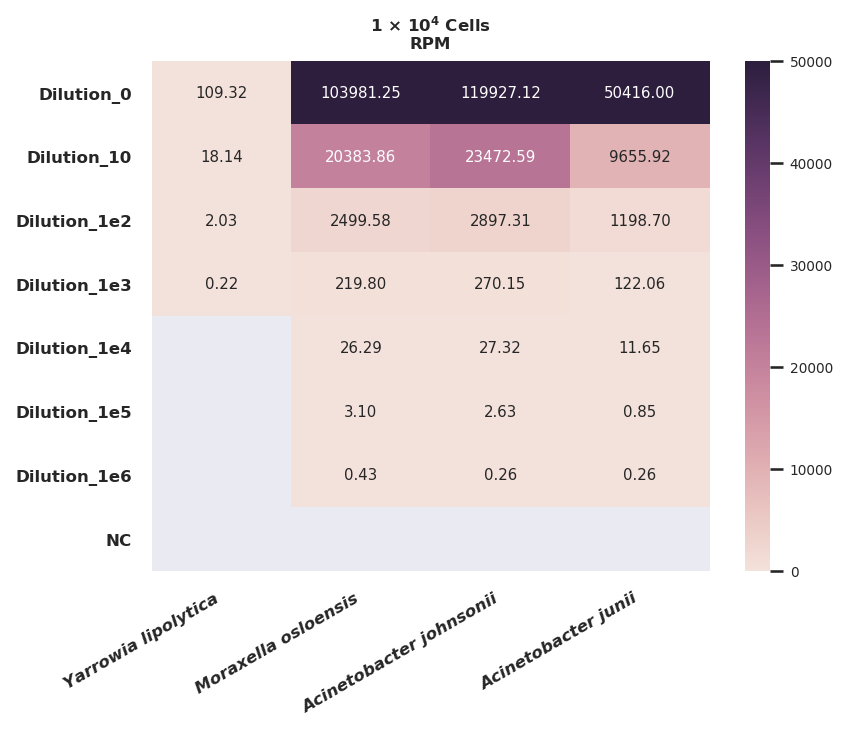

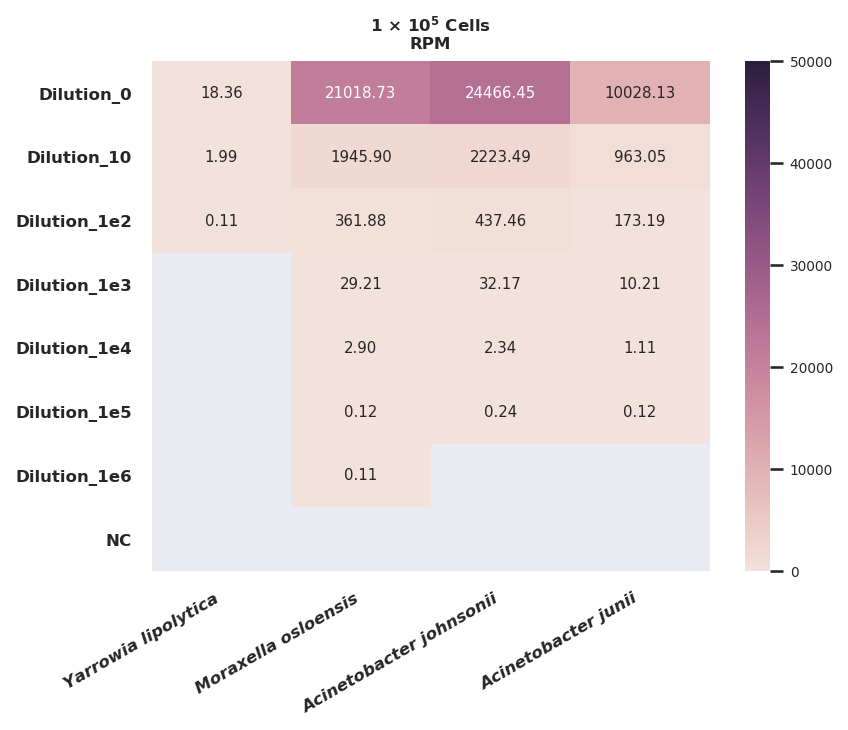

In [14]:
seaborn.set(font_scale=0.6)
cmap = seaborn.cubehelix_palette(as_cmap=True, light=0.9)
# 1e4 cells, left panel
fig = plt.figure(figsize=(6, 4.5))
df = simulated_plot_data['1e4_cells'][1]
seaborn.heatmap(df, cmap=cmap, mask=df.isnull(), xticklabels=1, yticklabels=1, annot=True, fmt='.2f', vmax=50000, vmin=0)
plt.title('1 × 10$^4$ Cells\nRPM', fontsize=8, fontweight='bold')
plt.xticks(style='italic', fontsize=8, rotation=30, horizontalalignment='right', fontweight='bold')
plt.yticks(fontsize=8, fontweight='bold')
plt.ylabel(None)
plt.show()
plt.close()
# 1e5 cells, right panel
fig = plt.figure(figsize=(6, 4.5))
df = simulated_plot_data['1e5_cells'][1]
seaborn.heatmap(df, cmap=cmap, mask=df.isnull(), xticklabels=1, yticklabels=1, annot=True, fmt='.2f', vmax=50000, vmin=0)
plt.title('1 × 10$^5$ Cells\nRPM', fontsize=8, fontweight='bold')
plt.xticks(style='italic', fontsize=8, rotation=30, horizontalalignment='right', fontweight='bold')
plt.yticks(fontsize=8, fontweight='bold')
plt.ylabel(None)
plt.show()
plt.close()

Plot figure 2c.

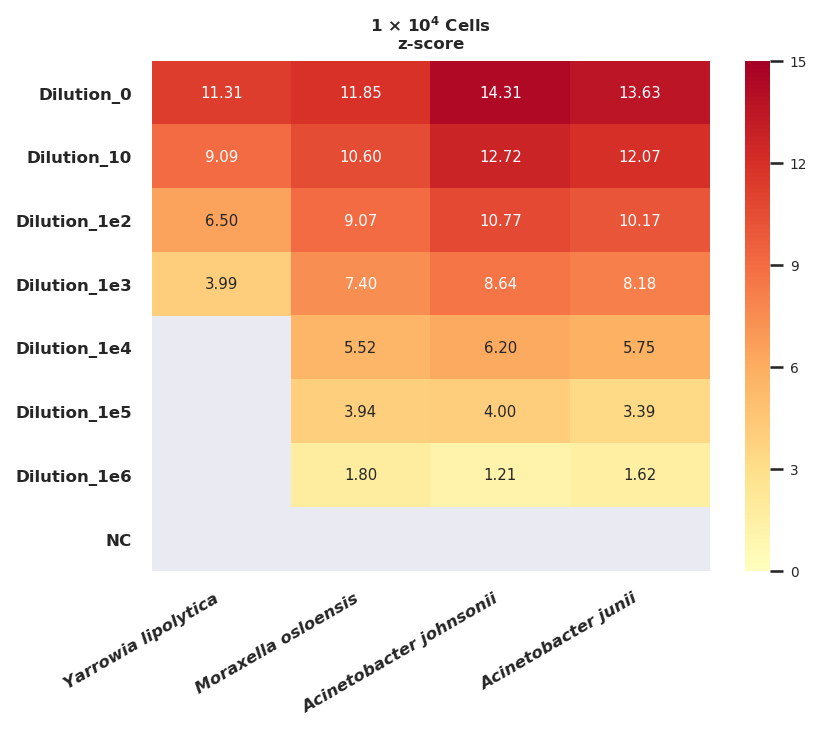

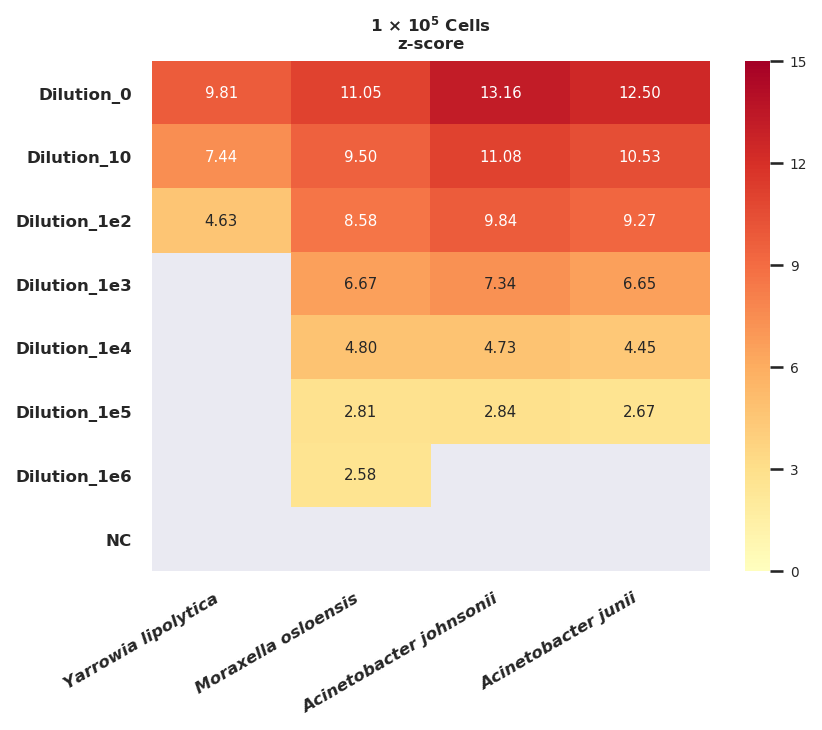

In [15]:
seaborn.set(font_scale=0.6)
# 1e4 cells, left panel
fig = plt.figure(figsize=(6, 4.5))
df = simulated_plot_data['1e4_cells'][0]
seaborn.heatmap(df, cmap='RdYlGn_r', mask=df.isnull(), xticklabels=1, yticklabels=1, cbar_kws={'ticks': list(range(0, 18, 3))},vmax=15,
                center=0, vmin=0, annot=True, fmt='.2f')
plt.title('1 × 10$^4$ Cells\nz-score', fontsize=8, fontweight='bold')
plt.xticks(style='italic', fontsize=8, rotation=30, horizontalalignment='right', fontweight='bold')
plt.yticks(fontsize=8, fontweight='bold')
plt.ylabel(None)
plt.show()
plt.close()
# 1e5 cells, right panel
fig = plt.figure(figsize=(6, 4.5))
df = simulated_plot_data['1e5_cells'][0]
seaborn.heatmap(df, cmap='RdYlGn_r', mask=df.isnull(), xticklabels=1, yticklabels=1, cbar_kws={'ticks': list(range(0, 18, 3))},vmax=15,
                center=0, vmin=0, annot=True, fmt='.2f')
plt.title('1 × 10$^5$ Cells\nz-score', fontsize=8, fontweight='bold')
plt.xticks(style='italic', fontsize=8, rotation=30, horizontalalignment='right', fontweight='bold')
plt.yticks(fontsize=8, fontweight='bold')
plt.ylabel(None)
plt.show()
plt.close()

## 3. Analysis of CSF samples
This section analyzes the sequencing data of the 28 CSF specimens of 28 patients (13 with suspected CNS infections and 15 diagnosed with non-CNS-infection). Non-human non-spike reads are deposited under SRA project accession PRJNA665328. Sample metadata and alignment result are included as part of this reproducible analysis in the *csf_samples* directory.

### Data Preparation
Load data.

In [16]:
# alignment results of non-human non-spike reads from bioinformatics analysis
with open(os.path.join(WORK_DIR, 'csf_samples', 'alignment_results_csf.json')) as f:
    csf_alignment_results = json.load(f)

# metadata of sample
csf_sample_metadata = pd.read_excel(os.path.join(WORK_DIR, 'csf_samples', 'meta.xlsx'))

# taxid-scientific name map of pathogens detected in csf samples
with open(os.path.join(WORK_DIR, 'csf_samples', 'pathogens_taxid2name.json')) as f:
    pathogen_names = json.load(f)

Get rpm and zscore data.

In [17]:
# helper functions
def sort_by_frequence(alignment_results, models):
    frequence_stats = {}
    for sample_name, sample_result in alignment_results.items():
        for taxid, reads in sample_result.items():
            if taxid in models:
                frequence_stats.setdefault(taxid, {'frequence': 0, 'model_frequence': models[taxid]['frequence']})['frequence'] += 1
    sorted_taxid = sorted(frequence_stats.keys(),
                          key=lambda x: (frequence_stats[x]['frequence'], frequence_stats[x]['model_frequence'], -int(x)),
                          reverse=True)
    for taxid in models.keys():
        if taxid not in sorted_taxid:
            sorted_taxid.append(taxid)
    return sorted_taxid

def get_rpm_of_pathogens(alignment_results, sample_metadata, pathogens):
    rpms = {}
    for taxid, scientific_name in pathogens.items():
        rpms[scientific_name] = []
        for i, row in sample_metadata.iterrows():
            if taxid in alignment_results[row.sample_name]:
                rpm = round(alignment_results[row.sample_name][taxid] / row.total_reads * 1_000_000, 2)
            else:
                rpm = np.nan
            rpms[scientific_name].append(rpm)
    rpm_df = pd.DataFrame(rpms, index=sample_metadata.sample_name)
    return rpm_df

background_taxids = sort_by_frequence(csf_alignment_results, labA_automated_models)
zscore_df, rpm_df = get_rpm_and_zscore(background_taxids, csf_alignment_results, csf_sample_metadata, labA_automated_models)
pathogen_rpm_df = get_rpm_of_pathogens(csf_alignment_results, csf_sample_metadata, pathogen_names)
zscore_rm = zscore_df.where((zscore_df > 3) | (zscore_df.isnull()), np.nan)
rpm_rm = rpm_df.where((zscore_df > 3) | (zscore_df.isnull()), np.nan)
rpm_df_all = pd.concat([rpm_df, pathogen_rpm_df], axis=1)
rpm_df_all_rm = pd.concat([rpm_rm, pathogen_rpm_df], axis=1)

### Plotting
Plot figure 3a.

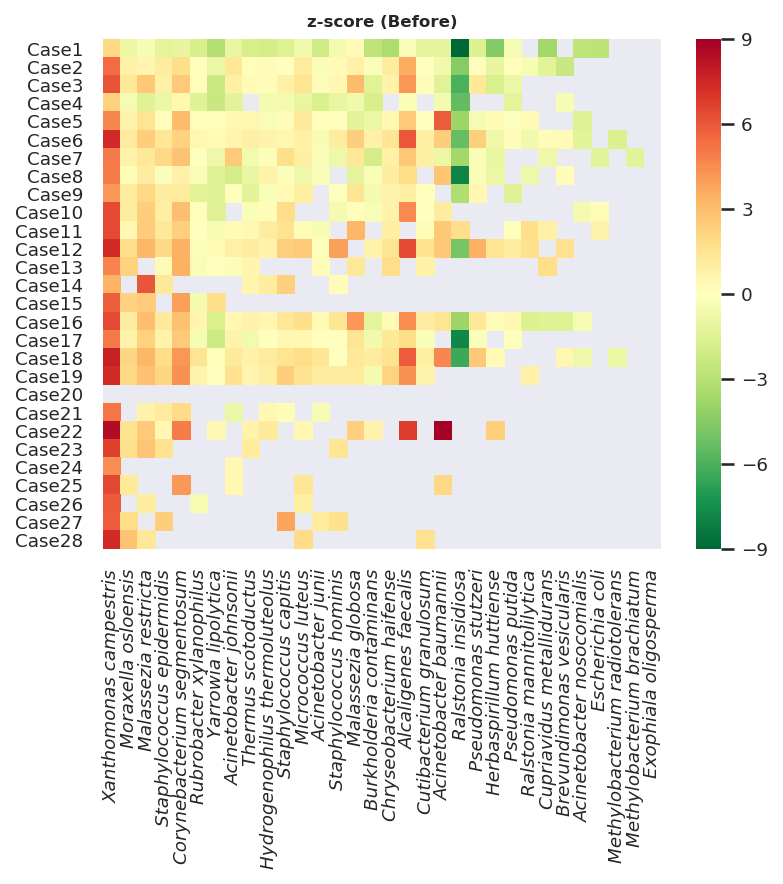

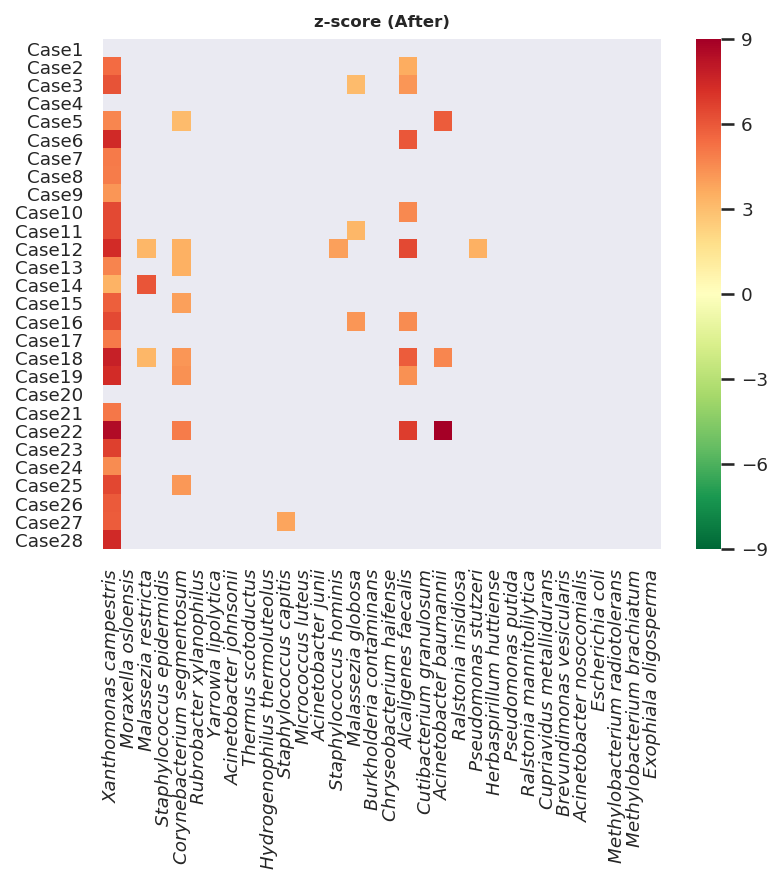

In [18]:
seaborn.set(font_scale=0.8)
# before filtering, left panel
fig = plt.figure(figsize=(6, 4.5))
seaborn.heatmap(zscore_df, cmap='RdYlGn_r', mask=zscore_df.isnull(), xticklabels=1, yticklabels=1, vmax=9, center=0, vmin=-9,
                cbar_kws={'ticks': list(range(-9, 12, 3))})
plt.title('z-score (Before)', fontsize=8, fontweight='bold')
plt.ylabel(None)
plt.xticks(style='italic')
plt.show()
plt.close()
# after filtering, right panel
fig = plt.figure(figsize=(6, 4.5))
seaborn.heatmap(zscore_rm, cmap='RdYlGn_r', mask=zscore_rm.isnull(), xticklabels=1, yticklabels=1, vmax=9, center=0, vmin=-9,
                cbar_kws={'ticks': list(range(-9, 12, 3))})
plt.title('z-score (After)', fontsize=8, fontweight='bold')
plt.ylabel(None)
plt.xticks(style='italic')
plt.show()
plt.close()

Plot figure 3b.

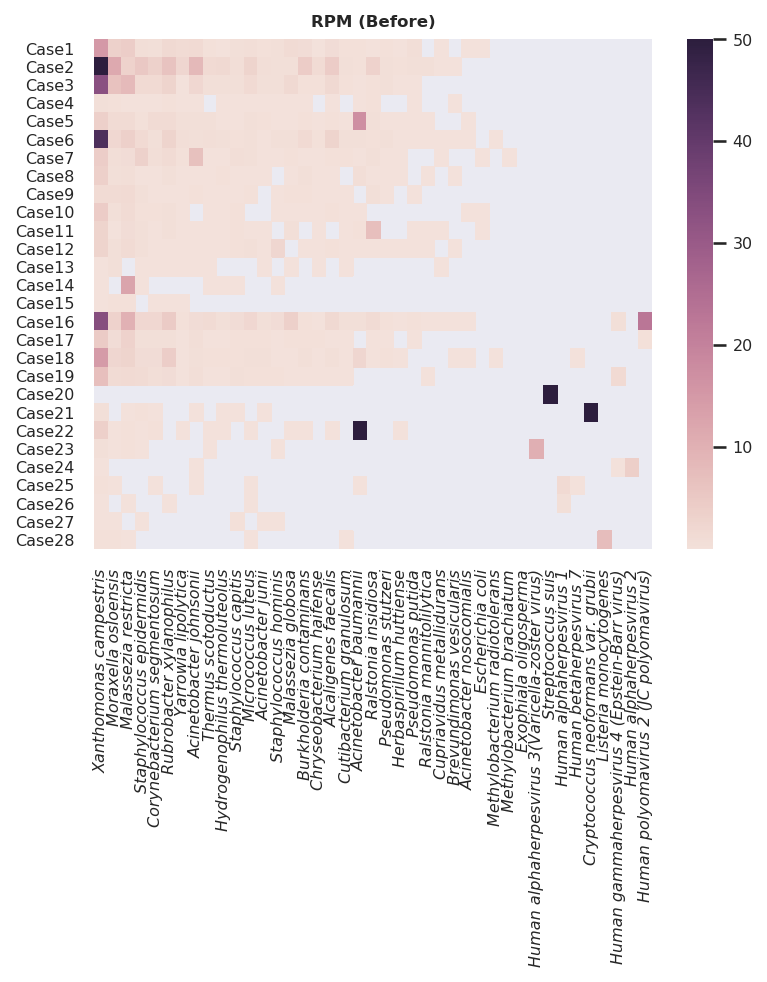

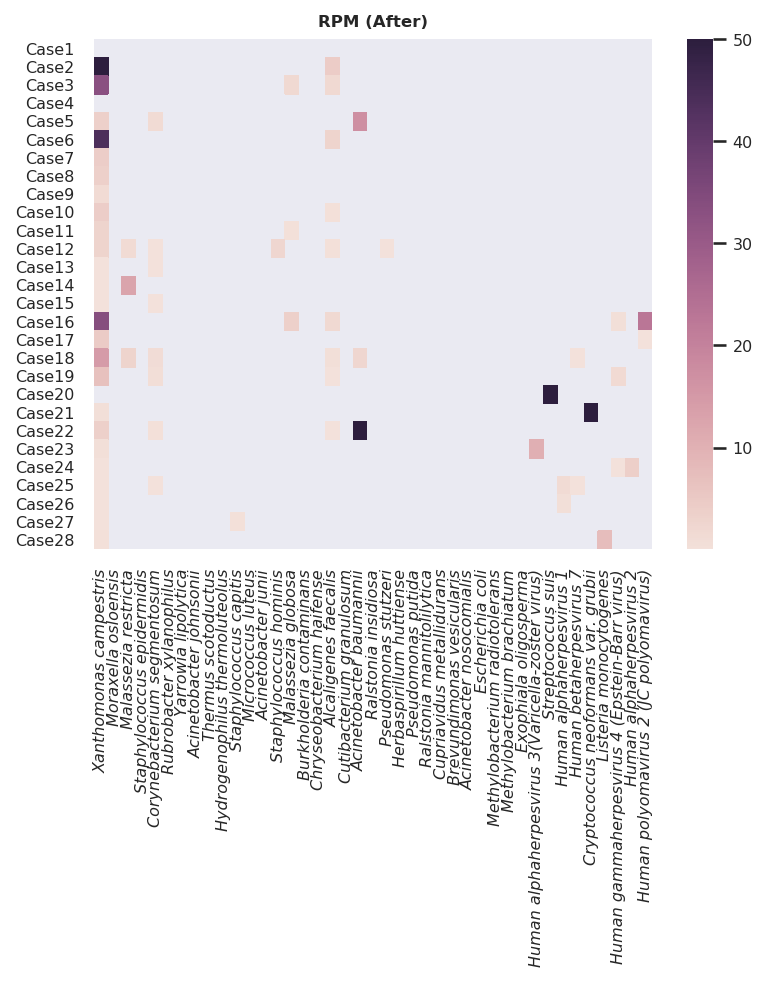

In [19]:
seaborn.set(font_scale=0.7)
cmap = seaborn.cubehelix_palette(as_cmap=True, light=.9)
# before filtering, left panel
fig = plt.figure(figsize=(6, 4.5))
seaborn.heatmap(rpm_df_all, cmap=cmap, mask=rpm_df_all.isnull(), xticklabels=1, yticklabels=1, vmax=50)
plt.title('RPM (Before)', fontsize=8, fontweight='bold')
plt.ylabel(None)
plt.xticks(style='italic')
plt.show()
plt.close()
# after filtering, right panel
fig = plt.figure(figsize=(6, 4.5))
seaborn.heatmap(rpm_df_all_rm, cmap=cmap, mask=rpm_df_all_rm.isnull(), xticklabels=1, yticklabels=1, vmax=50)
plt.title('RPM (After)', fontsize=8, fontweight='bold')
plt.ylabel(None)
plt.xticks(style='italic')
plt.show()
plt.close()

## 4. Analysis of background contaminants under different circumstances
This section analyzes the sequencing data of another two datasets(each n=72) of the synthetic DNA library preparation carried out in lab B by automated approach and in lab A by manual approach, respectively. Non-human non-spike reads are deposited under SRA project accession PRJNA665350. Sample metadata and alignment result are included as part of this reproducible analysis in the *training_set* directory.

### Data Preparation
Load data.

In [20]:
# alignment results of non-human non-spike reads from bioinformatics analysis
with open(os.path.join(WORK_DIR, 'training_set', 'alignment_results.json')) as f:
    alignment_results = json.load(f)

# metadata of sample
sample_metadata = pd.read_excel(os.path.join(WORK_DIR, 'training_set', 'meta.xlsx'))

# taxid-scientific name map
with open(os.path.join(WORK_DIR, 'taxid2name.json')) as f:
    scientific_names = json.load(f)

Get frequence statistics of background contaminants detected in lab A (Automated), lab B (Automated) and lab A (manual).

In [21]:
labA_automated_freq = get_frequence_stats(alignment_results, sample_metadata, lab='labA', method='automated')
labB_automated_freq = get_frequence_stats(alignment_results, sample_metadata, lab='labB', method='automated')
labA_manual_freq = get_frequence_stats(alignment_results, sample_metadata, lab='labA', method='manual')
contaminants_labA_automated = {taxid: frequence for taxid, frequence in labA_automated_freq.items() if frequence >= 10}
contaminants_labB_automated = {taxid: frequence for taxid, frequence in labB_automated_freq.items() if frequence >= 10}
contaminants_labA_manual = {taxid: frequence for taxid, frequence in labA_manual_freq.items() if frequence >= 10}

Data processing and function definition.

In [22]:
# helper functions
def get_x_lims(dfs, models, idx1, idx2, key='log_library_concentration'):
    if dfs[idx1] is not None and dfs[idx2] is not None and models[idx1] and models[idx2]:
        ylim = (min(get_y_coor(models[idx1], dfs[idx1][key].max()),
                    get_y_coor(models[idx2], dfs[idx2][key].max()),
                   dfs[idx1]['log_rpm'].min(), dfs[idx2]['log_rpm'].min()),
               max(get_y_coor(models[idx1], dfs[idx1][key].min()),
                    get_y_coor(models[idx2], dfs[idx2][key].min()),
                  dfs[idx1]['log_rpm'].max(), dfs[idx2]['log_rpm'].max()))
        xlim = ((min(dfs[idx1][key].min(), 
                         dfs[idx2][key].min()),
                min(get_x_coor(models[idx1], ylim[0]), max(dfs[idx1][key].max(), 
                         dfs[idx2][key].max()))),
                (min(dfs[idx1][key].min(),
                        dfs[idx2][key].min()),
                 min(get_x_coor(models[idx2], ylim[0]), max(dfs[idx1][key].max(), 
                         dfs[idx2][key].max()))))
    elif dfs[idx1] is not None and dfs[idx2] is not None:
        idx = list({k: v for k, v in models.items() if v is not None}.keys())[0]
        idxo = list(set([idx1, idx2]) - set([idx]))[0]
        ylim = (min(get_y_coor(models[idx], dfs[idx][key].max()), dfs[idxo]['log_rpm'].min()),
               max(get_y_coor(models[idx], dfs[idx][key].min()), dfs[idxo]['log_rpm'].max()))
        xlim = ((min(dfs[idx1][key].min(), dfs[idx2][key].min()),
                max(dfs[idx][key].max(), get_x_coor(models[idx], ylim[0]))),
               (min(dfs[idx1][key].min(), dfs[idx2][key].min()),
                max(dfs[idx][key].max(), get_x_coor(models[idx], ylim[0]))))
    elif dfs[idx1] is not None or dfs[idx2] is not None:
        df = dfs[idx1] if idx1 in dfs else dfs[idx2]
        xlim = ((df[key].min(), df[key].max()),
               (df[key].min(), df[key].max()))
    else:
        xlim = ((0, 0), (0, 0))
    return xlim

def get_x_coor(model, y):
    return (y - model['intercept']) / model['slope']

def plot_fig4(plot_data):
    ax_index = {0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]}
    colors = {0: 'b', 1: 'r'}
    key = 'log_library_concentration'
    seaborn.set(font_scale=0.5)
    fig, axes = plt.subplots(2, 2)
    for idx, taxid in enumerate(plot_data.keys()):
        a, b = ax_index[idx]
        ax = axes[a, b]
        species_name = scientific_names[taxid]
        dfs = plot_data[taxid]['dfs']
        models = plot_data[taxid]['models']
        for i, df in dfs.items():
            if models[i]:
                dfs[i] = df[df[key] <= models[i]['cutoff']]
        xlims = get_x_lims(dfs, models, 0, 1)
        if dfs[0] is not None:
            seaborn.scatterplot(x=key, y='log_rpm', data=dfs[0], ax=ax, alpha=0.8, color=colors[0])
            if models[0] is not None:
                line1 = pd.DataFrame.from_records([{key: x, 'log_rpm': get_y_coor(models[0], x)} for x in xlims[0]])
                seaborn.lineplot(x=key, y='log_rpm', data=line1, ax=ax, color=colors[0])
                text1 = f'$R^2$={round(math.pow(models[0]["rvalue"], 2), 3)} (p={models[0]["pvalue"]:.1e})'
                ax.text(0.58, 0.98, text1, horizontalalignment='left', verticalalignment='top',
                        fontsize=6, transform=ax.transAxes, color=colors[0])
        if dfs[1] is not None:
            seaborn.scatterplot(x=key, y='log_rpm', data=dfs[1], ax=ax, alpha=0.8, color=colors[1], marker='^')
            if models[1] is not None:
                line2 = pd.DataFrame.from_records([{key: x, 'log_rpm': get_y_coor(models[1], x)} for x in xlims[1]])
                seaborn.lineplot(x=key, y='log_rpm', data=line2, ax=ax, color=colors[1])
                text2 = f'$R^2$={round(math.pow(models[1]["rvalue"], 2), 3)} (p={models[1]["pvalue"]:.1e})'
                y = 0.92 if dfs[0] is not None and models[0] else 0.98
                ax.text(0.58, y, text2, horizontalalignment='left', verticalalignment='top',
                        fontsize=6, transform=ax.transAxes, color=colors[1])
        ax.set_title(species_name, fontweight='bold', style='italic', fontsize=8)
        ax.set_xlabel(r'$log_2$ library concentration (pM)', fontsize=8)
        ax.set_ylabel(r'$log_2$ RPM', fontsize=8)
    fig.tight_layout()
    plt.show()
    plt.close()

automated_lab_AB_plot_data, automated_manual_labA_plot_data = {}, {}
# taxid of Yarrowia lipolytica, Moraxella osloensis, Rubrobacter xylanophilus and Pseudomonas azotoformans.
taxids = ['4952', '34062', '49319', '47878']
for taxid in taxids:
    df_labA = get_df_of_taxid(taxid, alignment_results, sample_metadata, lab='labA', method='automated')
    df_labB = get_df_of_taxid(taxid, alignment_results, sample_metadata, lab='labB', method='automated')
    model_labA = labA_automated_models[taxid] if len(df_labA) >= 20 else None
    model_labB = get_model_of_taxid(df_labB, taxid) if len(df_labB) >= 20 else None
    automated_lab_AB_plot_data[taxid] = {'dfs': {0: df_labA, 1: df_labB}, 'models': {0: model_labA, 1: model_labB}}
    
# taxid of Yarrowia lipolytica, Moraxella osloensis, Ralstonia mannitolilytica and Roseomonas mucosa.
taxids = ['4952', '34062', '105219', '207340']
for taxid in taxids:
    df_automated = get_df_of_taxid(taxid, alignment_results, sample_metadata, lab='labA', method='automated')
    df_manual = get_df_of_taxid(taxid, alignment_results, sample_metadata, lab='labA', method='manual')
    model_automated = labA_automated_models[taxid] if len(df_automated) >= 20 else None
    model_manual = get_model_of_taxid(df_manual, taxid) if len(df_manual) >= 20 else None
    automated_manual_labA_plot_data[taxid] = {'dfs': {0: df_automated, 1: df_manual}, 'models': {0: model_automated, 1: model_manual}}

### Plotting
Plot figure 4a. Blue dot denotes automated library preparation in lab A, red triangle denotes automated library preparation in lab B.

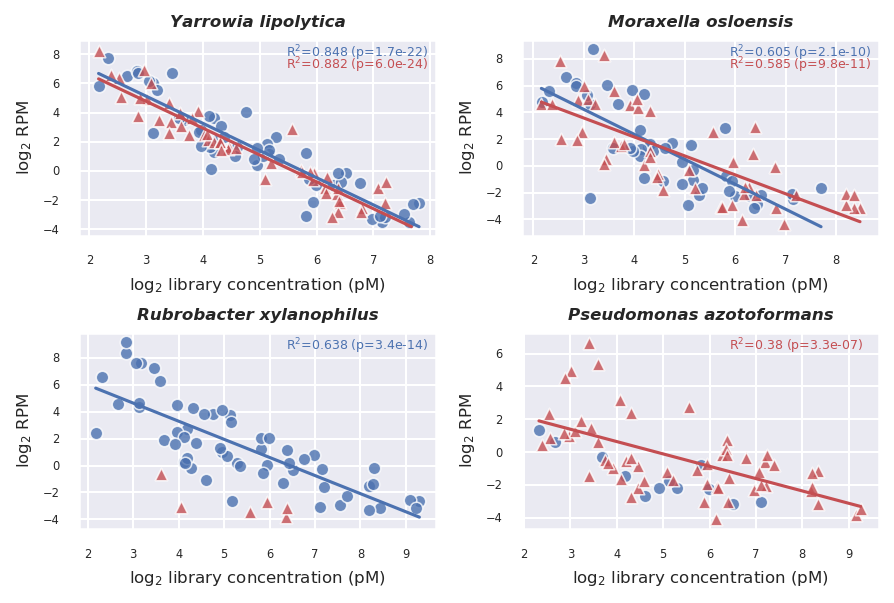

In [23]:
plot_fig4(automated_lab_AB_plot_data)

Plot figure 4b. Blue dot denotes automated library preparation in lab A, red triangle denotes manual library preparation in lab A.

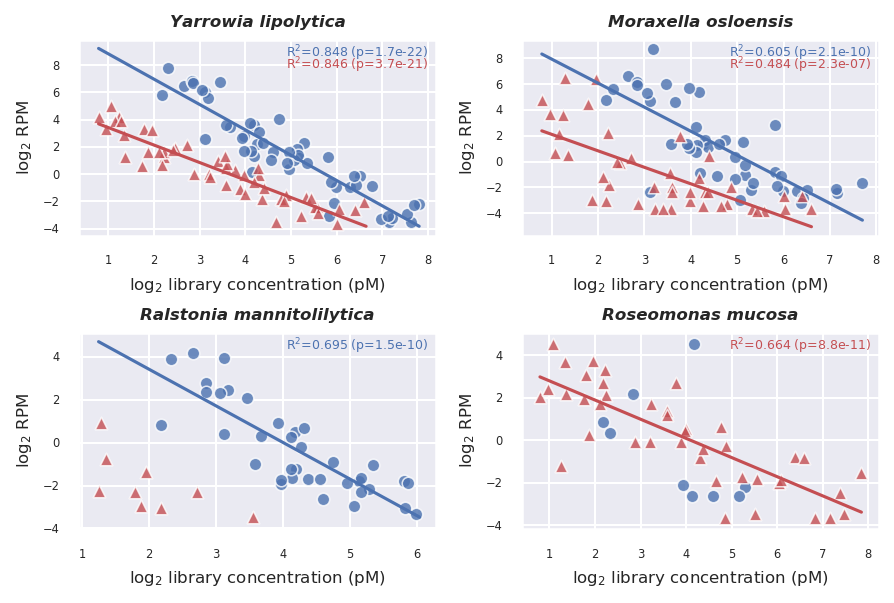

In [24]:
plot_fig4(automated_manual_labA_plot_data)

### Export data
Export data requeired for figure 4b and figure 4d.

In [25]:
contaminants_labA_automated_df = pd.DataFrame.from_dict(
    {'taxid': list(contaminants_labA_automated.keys()), 'labA_automated_frequence': list(contaminants_labA_automated.values())})
contaminants_labB_automated_df = pd.DataFrame.from_dict(
    {'taxid': list(contaminants_labB_automated.keys()), 'labB_automated_frequence': list(contaminants_labB_automated.values())})
contaminants_labA_manual_df = pd.DataFrame.from_dict(
    {'taxid': list(contaminants_labA_manual.keys()), 'labA_manual_frequence': list(contaminants_labA_manual.values())})
frequence_df = pd.merge(pd.merge(contaminants_labA_automated_df, contaminants_labB_automated_df, how='outer', on='taxid'),
                       contaminants_labA_manual_df, how='outer', on='taxid')
taxid_name_df = pd.DataFrame.from_dict({'taxid': list(scientific_names.keys()), 'scientific_name': list(scientific_names.values())})
export_data_df = pd.merge(taxid_name_df, frequence_df, how='right', on='taxid').sort_values(by=['labA_automated_frequence', 'taxid'],
                                                                                           ascending=False)
export_data_df.to_excel(os.path.join(WORK_DIR, 'training_set', 'frequence_lab_method.xlsx'), index=None)

Plot figure 5

In [82]:
def plot_spiked_csf(model_df, model_result_df, result_df):
    result_df['label'] = result_df.sample_name.map(lambda x: 'pos' if x.split('-')[0] in ['mos', 'pae', 'high'] else 'neg')
    taxid_lable_map = {562: 'eco', 287: 'pae', 34062: 'mos'}
    for i, taxid in enumerate(taxid_lable_map.keys()):
        row = model_df[model_df.taxid == taxid].iloc[0]
        fig, ax = plt.subplots()
        model_res = model_result_df[model_result_df.taxid == taxid]
        model_res = model_res[model_res.log_con <= row.cutoff]
        model_res['label'] = 'model'
        res = result_df[(result_df.taxid == taxid) & 
                        ((result_df.sample_name).str.contains(taxid_lable_map[taxid]) | (result_df.label == 'neg'))]
        xlim = min(res['log_con'].min(), model_res['log_con'].min()) - 0.1, max(
            res['log_con'].max(), model_res['log_con'].max()) + 0.1
        line_z = pd.DataFrame.from_records([{'log_con': x,
                                           'log_rpm': row['intercept'] + row['slope'] * x + z * row['sd']}
                                            for x in xlim for z in (-3, 3)])
        seaborn.lineplot(x='log_con', y='log_rpm', data=line_z, ax=ax, color='grey', alpha=0.5)
        line = pd.DataFrame.from_records([{'log_con': x,
                                           'log_rpm': row['intercept'] + row['slope'] * x} for x in xlim])
        seaborn.lineplot(x='log_con', y='log_rpm', data=line, ax=ax, color='red', linewidth=1, alpha=0.7)
        seaborn.scatterplot(data=pd.concat([model_res, res], axis=0),
                        x='log_con', y='log_rpm',  ax=ax, hue='label', alpha=0.9,
                        hue_order=['model', 'pos', 'neg'], palette=['#4c72b0', '#F8766D', '#00BFC4'])
        atext = f'$R^2={round(math.pow(row["rvalue"], 2), 3)}$\np={row["pvalue"]:.1e}'
        ax.set_title(row['name'], fontweight='bold', style='italic', fontsize=11)
        ax.set_xlabel(r'$log_2$ library concentration (pM)', fontsize=11)
        ax.set_ylabel(r'$log_2$ RPM', fontsize=11)
        ax.legend().remove()
        fig.tight_layout()
        plt.show()
        plt.close()

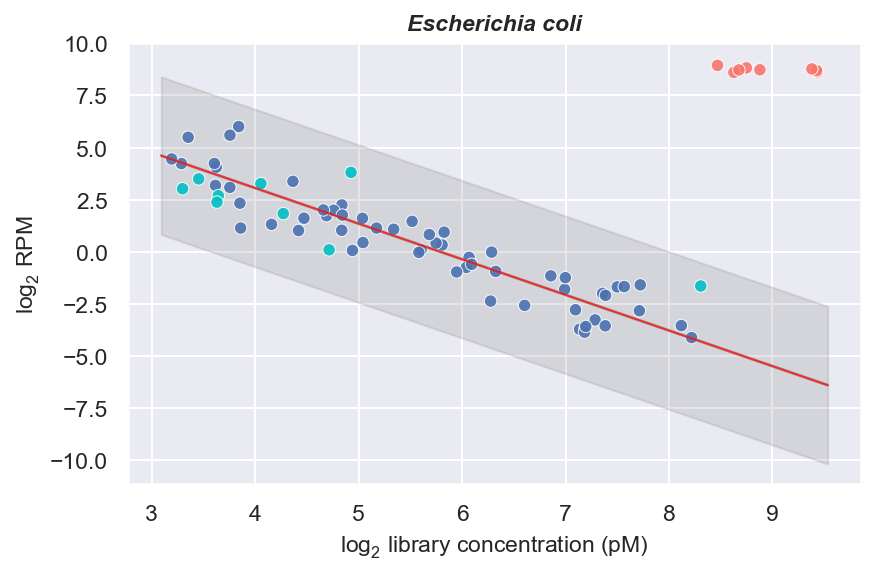

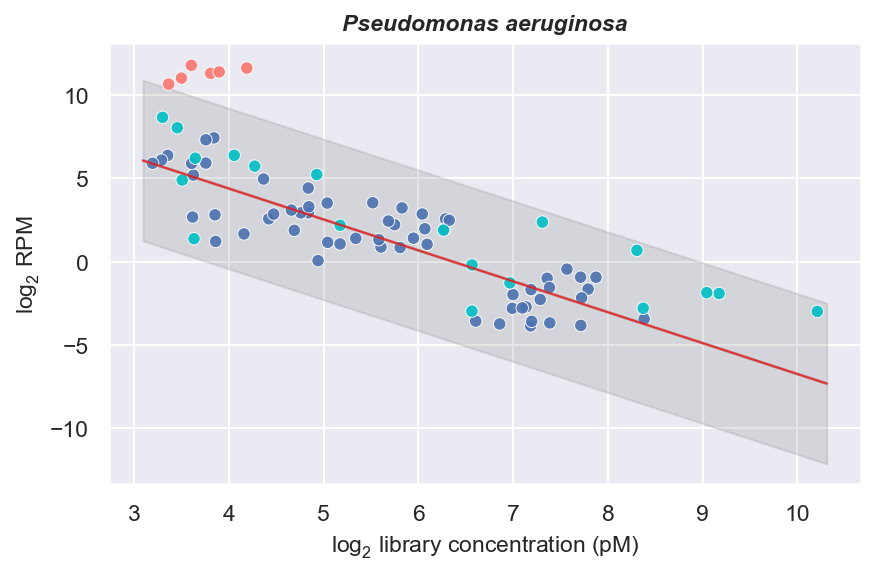

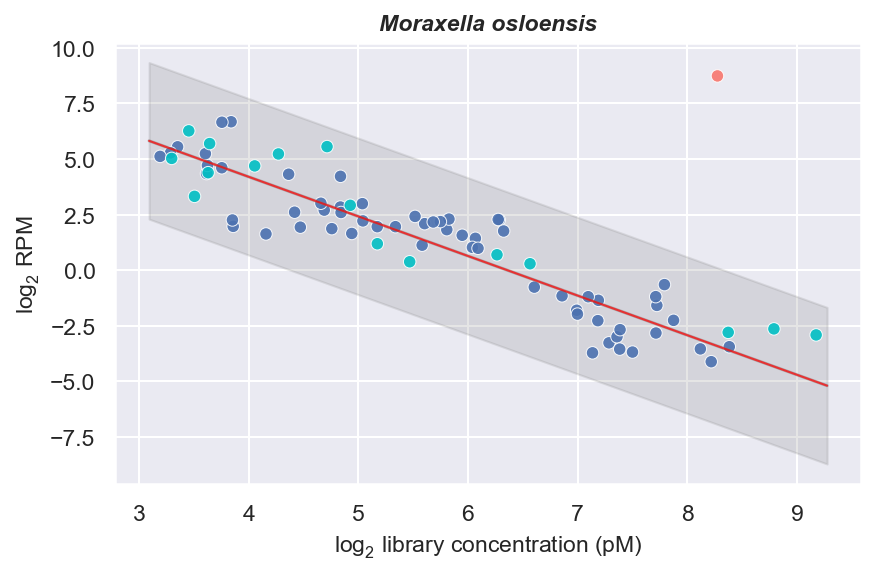

In [83]:
labC_model_sep_df = pd.read_excel(os.path.join(WORK_DIR, 'spiked_csf_samples', 'labC_model_sep.xlsx'))
labC_training_set_data_df = pd.read_excel(os.path.join(WORK_DIR, 'spiked_csf_samples', 'labC_training_set_data.xlsx'))
spiked_csf_meta = pd.read_csv(os.path.join(WORK_DIR, 'spiked_csf_samples', 'decontam', 'decontam_meta.csv'))
spiked_csf_data_df = pd.read_excel(os.path.join(WORK_DIR, 'spiked_csf_samples', 'labC_spiked_csf_data.xlsx'))
spiked_csf_data_df = pd.merge(spiked_csf_data_df, spiked_csf_meta, how='right', on='sample_name')
spiked_csf_data_df['log_con'] = spiked_csf_data_df.library_concentration.map(math.log2)
spiked_csf_data_df['log_rpm'] = spiked_csf_data_df.rpm.map(math.log2)
plot_spiked_csf(labC_model_sep_df[labC_model_sep_df.run == 'all'], labC_training_set_data_df, spiked_csf_data_df)

Plot supplemental figure 4c

/home/analysis/.conda/envs/core/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.04810229875075874 and the largest is 11.05138162252416.
  RuntimeWarning


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      80
number of groups                  2
test statistic              0.25733
p-value                       0.977
number of permutations          999
Name: PERMANOVA results, dtype: object


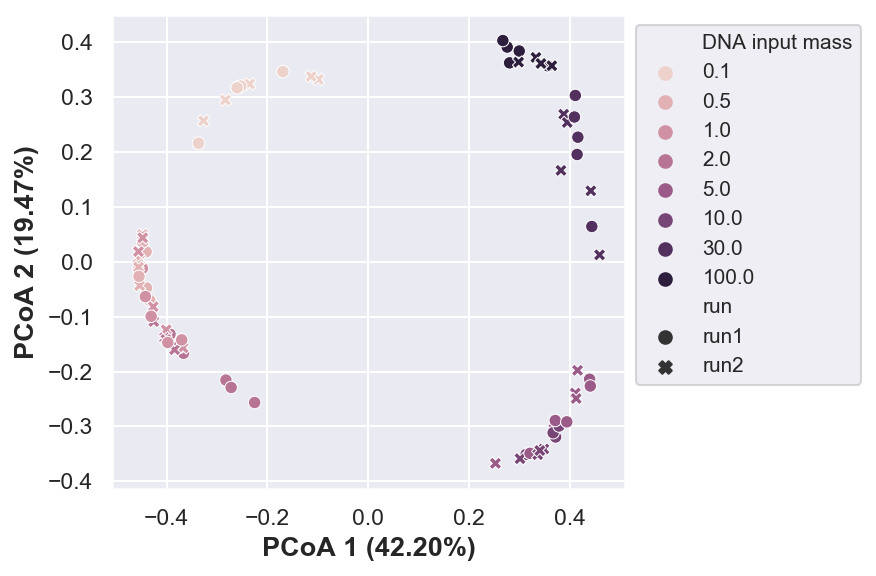

In [103]:
labC_pcoa_data = pd.read_excel(os.path.join(WORK_DIR, 'spiked_csf_samples', 'labC_pcoa_data.xlsx'), index_col=[0]).T
labC_training_set_meta = pd.read_excel(os.path.join(WORK_DIR, 'spiked_csf_samples', 'labC_training_set_meta.xlsx'))
pcoa_test(labC_pcoa_data, labC_training_set_meta)

Plot supplemental figure 4d

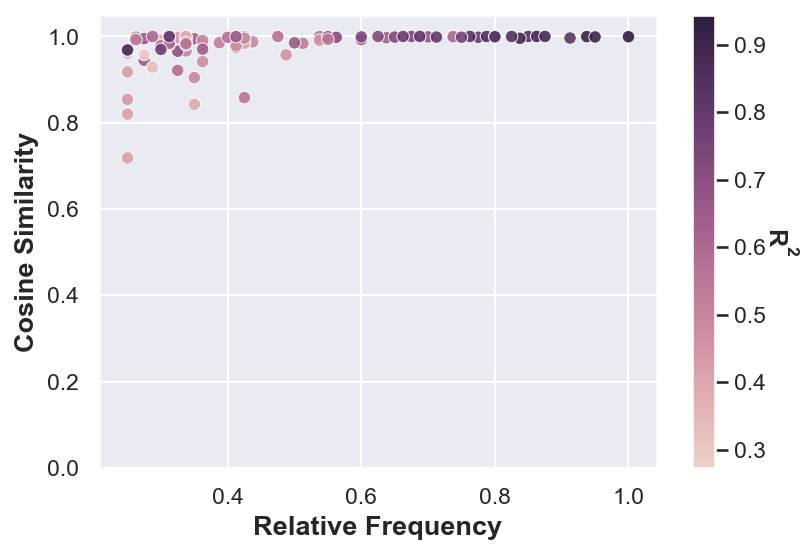

In [104]:
labC_model_sep_df = pd.read_excel(os.path.join(WORK_DIR, 'spiked_csf_samples', 'labC_model_sep.xlsx'))
plot_cosine_distance(labC_model_sep_df, total=80)

Plot supplemental figure 4e

In [105]:
def plot_paired_r2(model_df, total):
    res = []
    for taxid in set(model_df.taxid.values):
        taxid_df = model_df[model_df.taxid == taxid]
        run1 = taxid_df[taxid_df.run == 'run1']
        run2 = taxid_df[taxid_df.run == 'run2']
        run_all = taxid_df[taxid_df.run == 'all']
        f = run_all.frequence.values[0] / total
        res.append(dict(taxid=taxid, run1=run1.r2.values[0], run2=run2.r2.values[0], frequency=f))
    df = pd.DataFrame.from_records(res)
    seaborn.scatterplot(data=df, x='run1', y='run2', hue='frequency', alpha=0.9)
    plt.xlabel('Run1', fontsize=13, fontweight='bold')
    plt.ylabel('Run2', fontsize=13, fontweight='bold')
    norm = plt.Normalize(df.frequency.min(), df.frequency.max())
    sm = plt.cm.ScalarMappable(cmap=seaborn.cubehelix_palette(as_cmap=True), norm=norm)
    sm.set_array([])
    clb = plt.colorbar(sm)
    clb.ax.get_yaxis().labelpad = 15
    clb.ax.set_ylabel('Relative Frequency', fontweight='bold', rotation=270)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend().remove()
    plt.show()
    plt.close()

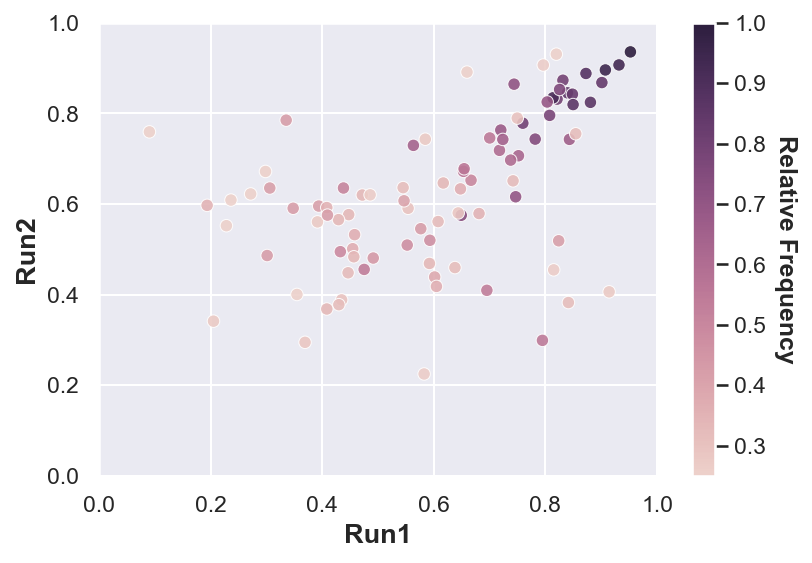

In [106]:
plot_paired_r2(labC_model_sep_df, total=80)